<img src = 'image/k-water_logo.png' alt = 'Drawing' style = 'width: 200px;'/>
<p style = 'font-size:30px; line-height:1em'>[Notebook] 수압 데이터를 활용한 관로 누수위치 탐지 </p>

# 분석개요
## 분석주제 및 목표
* 유수율이 낮고, 공급지역이 방대한 인프라 저 밀집도 농어촌지역의 효과적 누수 저감을 위해 빅데이터 기반 누수위치 탐지 모델 개발
* 관망해석모델의 해석 수압(estimated_pressure)과 실제 측정된 실측 수압(measured pressure)의 상관성(correlation)이 최대가 되는 절점(node)별 누수량 최적해를 찾아 누수 위치를 탐지  

** 최적해: 주어진 문제에 대한 최선의 해결책(해)를 의미함.  
** 해석수압: EPANET에 내장된 관망해석모델(수리학적 모델)로 계산된 수압    
** 실측수압: 수압 측정 기기에서 실제로 측정된 수압


## 분석과정
분석환경 설정 > 데이터 가져오기 > 데이터 전처리 > 모델링  

* 데이터 전처리: 관망해석모델에 필요한 누수지점, 수압측정지점 설정  
* 모델링: 누수배분 최적의 해 도출
* 사용된 알고리즘: 총 2개 모델사용(GA, 시행착오법)

## 데이터 설명
* kwater_recipe05_dataset.inp
  - 데이터 유형: inp 파일
  - 파일 크기: 41KB
  - 데이터 수집: 정읍시 정우17블록 구역에서 수집
  - 데이터 내용: EPANET프로그램에서 추출된 관망 정보(파이프, 펌프, 탱크, 저장소, 밸브 및 노드 등)가 들어있는 파일

* kwater_recipe05_dataset1.csv
  - 데이터 유형: csv 파일
  - 파일 크기: 관측치 9개(행), 변수 1개(열), 162B
  - 데이터 내용: 임의의 누수가 생성된 절점 이름

* kwater_recipe05_dataset2.csv
  - 데이터 유형: csv 파일
  - 파일 크기: 관측치 9개(행), 변수 8개(열), 402B
  - 데이터 내용: 임의로 생성된 누수 발생 시에 측정된 유량, 수압 데이터(22년 5월 14~15시 측정)

<img src = 'image/blindtest.png' alt = 'Drawing' style = 'width: 600px;'/>


## 주요변수 설명
* kwater_recipe05_dataset.inp
    * inp파일은 EPANET프로그램에서 관망 정보를 입력하여 만들어진 파일이며, 관망해석모델 시뮬레이션에서 관망 설정 파일로 쓰이는 파일
    * 설정 항목 수 : 25개(파이프, 펌프, 탱크, 저장소, 밸브 및 노드 등)
    * 자세한 변수 설명은 doc폴더의 data_product_meta_guide 참조
    * 아래는 실제 지도에서의 관망을 시각화한 것
    * 점은 수압/유량을 측정하는 절점을 의미하며, 절점을 잇는 선은 물이 흐르는 관을 의미
    * 유량/수압이라 표시된 곳은 정우17시점부이며, 유량계와 수압계가 존재함.
    * 수압이라고 표시된 곳은 수압계만 존재함. 

<img src = 'image/jeongwoo17.jpg' alt = 'Drawing' style = 'width: 350px;'/>   

* kwater_recipe05_dataset1.csv
    * 총 변수 수: 2개  
    * 임의의 누수가 생성된 절점 이름
        - 누수 CASE 번호: 1개 (CASE)  
        - 누수가 일어난 절점: 1개(LEAK_JUNC)
    
* kwater_recipe05_dataset2.csv
    * 총 변수 수: 8개  
    * 임의로 생성된 누수 발생 시에 측정된 유량, 수압 데이터  
        - 누수 CASE 번호: 1개 (CASE)  
        - 정우17 시점부의 유량과 수압: 2개 (START_FL(유량), START_PR(수압))  
        - 절점별 수압($cmh$) 데이터: 5개  (MAHANG, KUKJEONG, CHANGJEON, HWANGJEON, YEDONG)    


# 분석환경 설정

In [1]:
# 분석환경설정

# 작업 디렉토리 설정
# chdir(): 디렉토리의 위치를 바꿈
# environ(): 환경변수 설정
import os
os.chdir(f"{os.environ['HOME']}/recipe05")

# warnings 제거
# filterwarnings(): warnings 제거 옵션 설정
import warnings
warnings.filterwarnings('ignore')

## 패키지 불러오기

* import wntr: EPANET 관망해석 모델의 Python 패키지
* import pandas as pd: 데이터 조작
* import numpy as np: 데이터 조작
* import pygad: 유전 알고리즘
* import matplotlib.pylab as plt: 시각화
* import seaborn as sns: 시각화
* from sklearn.metrics import mean_squared_error: mse계산
* from math import sqrt: rmse계산
* from scipy.stats import pearsonr: 피어슨 상관계수
* import itertools: 함수 호출 시 계속 그 다음 값을 반환하는 객체인 이터레이터(iterator)사용  
* import openpyxl: 엑셀로 저장
* import joblib: 코드 실행된 데이터 불러오기

In [2]:
# 패키지 불러오기
import wntr
import pandas as pd 
import numpy as np
import pygad
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt 
from scipy.stats import pearsonr
import itertools
import openpyxl 
import joblib  

# 데이터 가져오기

In [3]:
# 관망해석모델(Epanet2.2) 의 .inp 파일 불러오기

# wntr.network.WaterNetworkModel(): 관망모델 구축
inp_file = 'input/kwater_recipe05_dataset.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

<img src = 'image/jeongwoo17.jpg' alt = 'Drawing' style = 'width: 350px;'/>   

위 사진은 실제 지도에서의 관망이며, .inp파일에 위 사진의 관망정보가 담겨있습니다.

In [4]:
# 관망해석모델 확인
num_junctions = wn.num_junctions  # 절점의 수 
num_pipes = wn.num_pipes   # 파이프의 수
print('절점의 수:', num_junctions)
print('파이프의 수:', num_pipes)

절점의 수: 31
파이프의 수: 36


## 실제 누수지점 확인

In [5]:
# 데이터 불러오기

# read_csv('경로/파일명'): 판다스로 csv데이터를 불러옴
leak_point_df = pd.read_csv('input/kwater_recipe05_dataset1.csv')  

In [6]:
# 인덱스 변경

# set_index('컬럼'): 컬럼으로 인덱스 지정
leak_point_df = leak_point_df.set_index(['CASE'])
leak_point_df

,LEAK_JUNC
CASE,
1,YEDONG
2,MAHANG
3,YEDONG/MAHANG
4,CHANGJEON
5,CHANGJEON
6,CHANGJEON
7,HWANGJEON
8,CHANGJEON/HWANGJEON
9,YEDONG/MAHANG/CHANGJEON


## 관망해석모델 시뮬레이션 옵션 설정
임의로 생성된 누수 시에 측정된 유량, 수압 데이터로 관망해석모델의 누수 지점을 설정합니다.

In [7]:
# 데이터 불러오기
flow_pressure_df = pd.read_csv('input/kwater_recipe05_dataset2.csv') 
flow_pressure_df = flow_pressure_df.set_index(['CASE'])  # 'CASE'변수로 인덱스 지정
flow_pressure_df

,START_FL,START_PR,MAHANG,KUKJEONG,CHANGJEON,HWANGJEON,YEDONG
CASE,,,,,,,
1,12,59.65,49.7,51.7,45.4,53.1,46.9
2,13,58.50,43.1,44.1,37.8,45.6,51.1
3,21,56.82,39.4,40.1,33.9,41.3,41.4
4,9,60.36,48.5,48.7,41.9,49.3,53.3
5,12,58.98,43.9,40.0,32.3,38.5,51.6
6,14,58.58,41.0,35.8,27.7,33.9,50.0
7,7,61.37,50.1,51.2,44.6,43.3,54.1
8,14,58.64,41.6,36.2,27.5,27.3,50.5
9,25,55.29,33.1,30.4,38.7,29.6,38.9


MAHANG, KUKJEONG, CHANGJEON, HWANGJEON, YEDONG 컬럼의 데이터는 각 절점의 누수 CASE별 수압을 의미합니다.

In [8]:
# 수압측정 지점 - 정우17시점부의 'START_FL', 'START_PR' 컬럼 제외 후 df 생성

# pd.DataFrame(): 데이터프레임 생성
# drop(행/열, axis = 0/1(행/열), inplace(True: 바꾼 df으로 원래 df를 대체)): 행 또는 열을 삭제
pressure_df = pd.DataFrame(flow_pressure_df)
pressure_df.drop(['START_FL', 'START_PR'], axis = 1, inplace = True)

# 정우17시점부의 유량,수압 - 'START_FL', 'START_PR'컬럼만 있는 df
first_part_df = pd.DataFrame(flow_pressure_df)
first_part_df.drop(pressure_df.columns, axis = 1, inplace = True)

In [9]:
# 정우17시점부의 유량,수압 df
first_part_df

,START_FL,START_PR
CASE,,
1,12,59.65
2,13,58.50
3,21,56.82
4,9,60.36
5,12,58.98
6,14,58.58
7,7,61.37
8,14,58.64
9,25,55.29


In [10]:
# 수압측정 지점(누수지점) df
pressure_df

,MAHANG,KUKJEONG,CHANGJEON,HWANGJEON,YEDONG
CASE,,,,,
1,49.7,51.7,45.4,53.1,46.9
2,43.1,44.1,37.8,45.6,51.1
3,39.4,40.1,33.9,41.3,41.4
4,48.5,48.7,41.9,49.3,53.3
5,43.9,40.0,32.3,38.5,51.6
6,41.0,35.8,27.7,33.9,50.0
7,50.1,51.2,44.6,43.3,54.1
8,41.6,36.2,27.5,27.3,50.5
9,33.1,30.4,38.7,29.6,38.9


총 누수량을 맞추기 위해 5개의 절점 중 4개로 누수량을 배분한 뒤 나머지 누수량을 나머지 하나의 절점에 배분 합니다.  
junctions1에 4개 절점을, junctions2에 나머지 하나의 절점을 지정합니다.

In [11]:
# 측정된 데이터 분리

# columns: df의 컬럼명들을 불러옴
all_junctions = pressure_df.columns  # MAHANG, KukJeon, CHANGJEON, HWANGJEON, YEDONG
junctions1 = pressure_df.columns[0:-1]  # MAHANG, KUKJEONG, CHANGJEON, HWANGJEON
junctions2 = pressure_df.columns[-1]  # YEDONG

print('junctions1:', junctions1)
print('junctions2:', junctions2)

junctions1: Index(['MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON'], dtype='object')
junctions2: YEDONG


## 유압분석 옵션 설정

관망해석을 실시 하기 위해 유압옵션을 지정해줍니다.

In [12]:
# WNTR을 이용한 유압분석 옵션 설정
wn.options.time.duration = 0  # 시뮬레이션 지속시간
wn.options.hydraulic.demand_model = 'DDA'  # DDA:수요 기반 유압 시뮬레이션/PDA:압력 기반 시뮬레이션

# 누수 위치의 최적해 도출
* 본 과제는 정우17시점부의 유량과 수압 데이터, 5곳의 절점 수압 데이터를 활용해 절점들에 유량을 배분하고, 물 수요가 적은 시간대(14~15시)에 누수를 만들었습니다.  물 수요가 적은 시간대이기 때문에 유량이 거의 없어야하는데, 임의로 누수를 만든 절점은 유량이 많을 것입니다. 그러므로 유량이 제일 많은 곳을 누수로 간주하여 누수위치를 탐지합니다.
* 5곳의 절점에는 유량계가 없고, 각 절점의 수압 데이터를 이용해 절점의 유량을 예측(배분)하는 것이기 때문에 정확한 유량(누수량)은 알 수 없습니다. 그러므로 최적의 누수배분을 찾기위해 최적해를 도출하는 알고리즘인 GA와 시행착오법을 사용합니다.
* GA의 적합도함수는 피어슨 상관계수이며, GA는 상관계수가 증가하는 방향으로 실행되도록 설정, 기준이 되는 횟수(본 과제는 7회)가 넘어가도 상관계수가 증가하지 않을 때의 해를 최적해로 결정합니다.
* 시행착오법에서 해는 해석 수압과 실측 수압의 상관성이 최대인 누수배분의 경우의 수가 최적의 해입니다.
* 두 알고리즘 모두 상관계수의 제곱으로 해들을 비교해 최적의 해를 결정합니다.

## 유전 알고리즘(GA)

**유전 알고리즘(GA, Genetic Algorithm)** 에 대한 설명은 **doc폴더의 레시피05_설명보충자료.pdf** 를 참고하시면 됩니다. 

### GA의 초기집단 수, 교차유형, 돌연변이 확률 설정

In [13]:
# GA 옵션 설정

# 초기 집단 수 지정
num_generations = 1000  # 최대 세대 수
num_parents_mating = 100  # 선택되는 부모 유전자의 수(상위 적합도인 부모 선택)
sol_per_pop = 200  # 한 세대(generation)에서 생성되는 해(염색체)의 개수
num_genes = len(junctions1)  # 유전자 개수
gene_type = [float, 3]  # 각 유전의 형태, 개수
# 유전자 예시 - [0.683 1.977 8.147 0.355]
# 1개의 유전자에 총 4개의 염색체가 들어있으며, 염색체의 형식은 소수3째 자리까지 표현되는 실수

# 교차 옵션 지정
# crossover_type = 'single_point'
# 부모 염색체에서 무작위로 교차점(한 지점)을 선택하여 교차점 이전에는 한 부모의 유전물질을, 교차점 이후에는 다른부모의 유전물질을 복사
# parent_selection_type = 'sss' 
# 일부(적합도가 낮은) 염색체가 제거되고 새 염색체가 그 자리에 배치
init_range_low = 0  # 초기 모집단의 유전 값이 선택되는 무작위 범위의 하한 값
init_range_high = 10  # 초기 모집단의 유전 값이 선택된 무작위 범위의 상한값
parent_selection_type = 'sss'  # 부모 선택 유형, sss(steady-state selection)
crossover_type = 'single_point'  # 교차유형, single_point(단일 지점 교차)

# 돌연변이 옵션 지정
# mutation_type = 'adaptive'
# 모집단의 성능에 따라 돌연변이 비율을 자동으로 조정하여 최적화 프로세스의 효율성을 개선하고 조기 수렴의 위험을 줄임.
# 모집단의 성능이 정체되면 높은 돌연변이 비율로, 성능이 좋아지면 낮은 돌연변이 비율로 자동으로 조정
mutation_type = 'adaptive'  # 돌연변이 타입, adaptive(적응형)
mutation_probability = [0.2, 0.1]  # 돌연변이 비율: 적합도값이 평균적합도보다 크면 돌엽변이 확률이 0.1, 적합도가 낮으면 0.2

### 적합도 함수 설정

* 본 과제에서 적합도함수(Fitness Function)은 피어슨 상관계수이며, GA는 상관계수가 증가하는 방향으로 실행되도록 설정됩니다.

* 적합도가 7회이상 변동 없을 때까지 선택, 교차, 변이, 대치를 반복합니다.

* 피어슨 상관계수(Pearson Correlation Coefficient, $r$)  
: 변수들 간의 선형관계의 강도를 측정하는 수치, -1 ~ +1사이의 값을 가지며, +1은 완벽한 양의 선형관계를, 0은 선형관계가 없는것을, -1은 완벽한 음의 선형관계를 나타냄.   

> $r_{XY}=$$ \sum((X_i-\bar X)(Y_i-\bar Y))\over\sqrt\sum((X_i-\bar X)^2) \sqrt \sum((Y_i-\bar Y))^2)) $  

* wntr패키지의 EpanetSimulator() 함수로 수리학적 모델(Hazen-Williams 손실수두공식)을 이용, GA로 각 절점에 분배된 유량(예상 누수량)으로 해석수압을 계산

>  $  h_l =10.666C^{-1.85} D^{-4.87} Q^{1.85} L$  
($h_l$:관망 수압(손실수두), $C$:유속계수, $D$:관경(mm), $Q$:유량(㎥/s), $L$:관로연장(m))

In [14]:
# fitness function 설정
def fitness_func(solution, solution_idx): 
    # 관망해석모델 준비
    wn.reset_initial_values()  # 관망 모델 리셋
    measured_pressure = pressure_df[all_junctions].loc[CASE]  # CASE별 실측수압
    measured_flow = first_part_df['START_FL'].loc[CASE]  # CASE별 실측유량
    reservoir = wn.get_node('1')  # 새로운 노드 생성
    reservoir.head_timeseries.base_value = first_part_df['START_PR'][CASE]  # head_timeseries.base_value: 교차점 수요, 저장소 헤드 및 펌프 속도를 포함하여 여러 네트워크 속성을 시계열로 저장
    
    if (solution<0).sum() > 0 :  # 해가 0보다 작은것이 하나라도 있으면 fitness가 0
        fitness = 0
    else :   
        i = 0
        for junctions_name in junctions1:  # 'MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON'
            junction = wn.get_node(junctions_name)
            junction.demand_timeseries_list[0].base_value = solution[i]/3600  # 교차점 수요 기본 값 변경, 3600으로 나누어 초당으로 계산
            i = i + 1
        #Last Logger
        junction = wn.get_node(junctions2)  # YEDONG
        junction.demand_timeseries_list[0].base_value = (first_part_df['START_FL'].loc[CASE]-sum(solution))/3600  # 총 누수량과 4개 절점의 유량의합의 차이를 예동절점에 배치
        
        sim = wntr.sim.EpanetSimulator(wn)  # EPANET내장 수리학적 모델로 계산
        results = sim.run_sim()  # EPANET 시뮬레이터를 실행
        estimated_pressure = results.node['pressure']  # 해석수압
        estimated_demand = results.node['demand']  # GA로 각 절점에 분배된 유량(누수량)

        # 적합도: 해석수압과 실측수압의 피어슨상관계수의 제곱(r-square)
        fitness = (pearsonr(estimated_pressure[all_junctions].loc[0], measured_pressure)[0])**2
        
    return fitness

In [15]:
# 세대(Generation)별 적합도(Fitness)와 변화 이전 세대와 비교한 적합도 차이(Change)를 출력하는 함수
def on_generation(ga_instance):
    global last_fitness
    print('Generation = {generation}'.format(generation = ga_instance.generations_completed))  # 세대
    print('Fitness    = {fitness}'.format(fitness = ga_instance.best_solution(pop_fitness = ga_instance.last_generation_fitness)[1]))  # 적합도
    print('Change     = {change}'.format(change = ga_instance.best_solution(pop_fitness = ga_instance.last_generation_fitness)[1] - last_fitness))  # 이전 세대와 비교한 적합도 차이
    last_fitness = ga_instance.best_solution(pop_fitness = ga_instance.last_generation_fitness)[1]  # 최적해의 적합도

### 각 CASE별 GA 실행
* Fitness(적합도)가 7회 이상 변동이 없을때까지 교배를 반복하여 최적해(best fitness solution) 도출
* 실행 시 EpanetSimulator의 입력 파일 및 출력 파일이(temp.bin, temp.inp. temp.rpt) 생기는데 무시하셔도 좋습니다.(코드로 삭제됨.)
* 실행시간이 30분 정도 소요됩니다.

In [16]:
# 시뮬레이션하는 CASE의 수
num_Simultaion_case = len(flow_pressure_df) + 1  # CASE: 1 ~ 9

<span style = 'background:#ffd33d'> 미리 학습된 모델을 사용하지 않고 직접 모델학습을 하려면 아래의 셀의 주석을 풀고 실행하세요 </span>

In [17]:
# # 미리 실행된 알고리즘을 사용하지 않고 직접 실행 하려면 이 셀의 주석을 풀고 실행하세요
# # 각 CASE별 유전 알고리즘 실행

# # 최적해를 담을 df 생성
# # range(시작값, 끝값, step): 시작값부터 끝값까지 step(간격)적용해서(default 1) 수열 생성
# solution_fitness_df = pd.DataFrame({'CASE':range(1, num_Simultaion_case), 'fittness':range(1, num_Simultaion_case)})
# solution_fitness_df.set_index(['CASE'])

# # 각 CASE별 유전 알고리즘 실행
# for CASE in range (1, num_Simultaion_case):
#     last_fitness = 0
#     print('CASE_'+str(CASE)) 
    
#     # 관망 해석 준비
#     wn.reset_initial_values()  # 관망 모델 리셋
#     measured_pressure = pressure_df[all_junctions].loc[CASE]  # 실측수압
#     measured_flow = first_part_df['START_FL'].loc[CASE]  # 실측유량
#     reservoir = wn.get_node('1')  # 배수지(새로운 노드) 생성
#     reservoir.head_timeseries.base_value = first_part_df['START_PR'][CASE]  # head_timeseries.base_value: 교차점 수요, 저장소 헤드 및 펌프 속도를 포함하여 여러 네트워크 속성을 시계열로 저장
    
#     # ga객체 생성
#     ga_instance = pygad.GA(num_generations = num_generations,
#                            num_parents_mating = num_parents_mating,
#                            sol_per_pop = sol_per_pop,
#                            num_genes = num_genes,
#                            gene_type = gene_type,
#                            fitness_func = fitness_func,
#                            # on_generation = on_generation,  # 세대마다 변하는 적합도 확인하려면 주석 풀고 실행
#                            init_range_low = init_range_low,
#                            init_range_high = init_range_high,
#                            parent_selection_type = parent_selection_type,
#                            crossover_type = crossover_type,
#                            mutation_type = mutation_type,
#                            mutation_probability = mutation_probability,
#                            stop_criteria = ['saturate_7']  # Fitness가 7회 이상 변동이 없을때까지 교배를 반복
#                       )

#     ga_instance.run()  # 유전 알고리즘을 실행
#     ga_instance.plot_fitness()  # 적합도값(fitness)이 세대별로 어떻게 진화하는지를 요약한 그림을 생성
    
#     # 최적의 해에 대한 정보 출력
#     solution, solution_fitness, solution_idx = ga_instance.best_solution(ga_instance.last_generation_fitness)  # pygad의 best_solution함수로 최적의 해 도출
#     print('Parameters of the best solution : {solution}'.format(solution = solution))  # 최적의 해
#     print('Fitness value of the best solution = {solution_fitness}'.format(solution_fitness = solution_fitness))  # 최적의 해의 적합도
#     print('Index of the best solution : {solution_idx}'.format(solution_idx = solution_idx))  # 최적의 해을 나타내는 유전의 인덱스
    
#     if ga_instance.best_solution_generation != -1:  
#         print('Best fitness value reached after {best_solution_generation} generations.'.format(best_solution_generation = ga_instance.best_solution_generation))  # 최적의 해의 세대
    
    
#     # 관망해석을 하기 위해 demand_timeseries_list에 GA의 최적값 저장
#     i = 0
#     for junctions_name in junctions1:  # 'MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON' 누수배분
#         junction = wn.get_node(junctions_name)
#         junction.demand_timeseries_list[0].base_value = solution[i]/3600  # demand_timeseries_list에 최적의 값 저장
#         i = i + 1 

#     junction = wn.get_node(junctions2)  # YEDONG 누수배분
#     junction.demand_timeseries_list[0].base_value = (first_part_df['START_FL'].loc[CASE]-sum(solution))/3600
        
        
#     # 관망해석 실시  
#     sim = wntr.sim.EpanetSimulator(wn)
#     estimated_results = sim.run_sim()
#     estimated_pressure = estimated_results.node['pressure']  # 수압 노드값을 변수에 저장
#     estimated_demand = estimated_results.node['demand']  # 수요 노드값을 변수에 저장
    
    
#     # 관망해석으로 도출된 해석수압, GA로 각 절점에 분배된 유량 결과 df 생성
#     if CASE==1:  # CASE 1일때
#         series_estimated_pressure = estimated_pressure
#         series_estimated_demand = estimated_demand
#     else:  # CASE 2~9일때
#         series_estimated_pressure = pd.concat([series_estimated_pressure, estimated_pressure], ignore_index  = True)
#         series_estimated_demand = pd.concat([series_estimated_demand, estimated_demand], ignore_index  = True)
        
#     solution_fitness_df['fittness'].loc[CASE] = solution_fitness   # 최적의 해의 적합도 df생성
#     print(sep = '\n')   
    
# # 필요없는 파일 삭제
# file_path = ['temp.bin', 'temp.inp', 'temp.rpt']
# for i in file_path:
#     if os.path.exists(i):
#         os.remove(i)

# # GA결과 저장
# joblib.dump({'solution_fitness_df':solution_fitness_df, 'series_estimated_demand':series_estimated_demand}, 'output/GA.pkl')  # 모델저장

유전 알고리즘 실행시(위의 셀) 나오는 plot은 각 케이스별 적합도가 세대가 지날수록 증가하고 있는 것을 보여주고 있습니다.  
적합도가 7번 이상 바뀌지 않으면 알고리즘 진행을 종료하고 마지막 세대를 최적해로 선정합니다.

In [18]:
# GA가 실행된 데이터 불러오기
# GA실행시 시간이 오래 걸리므로 빠르게 결과를 확인하고 싶으면 이 셀을 실행한 후 4.2GA평가로 넘어가면 됩니다.
with open('output/GA.pkl', 'rb') as f:
    GA_result = joblib.load(f)
locals().update(GA_result)  # dictionary data

solution_fitness_df = GA_result['solution_fitness_df']
series_estimated_demand = GA_result['series_estimated_demand']

## GA 평가

### GA로 각 절점에 분배된 유량과 정우17시점부의 유량 비교

In [19]:
# 최적의 해의 케이스별 적합도 df
solution_fitness_df.set_index(['CASE'])

,fittness
CASE,
1,1.000000
2,0.953913
3,0.999714
4,0.995513
5,0.999028
6,0.999985
7,0.999996
8,0.979397
9,0.999999


CASE2를 제외하고는 적합도가 1이거나 1에 가까운 것을 확인할 수 있습니다.

In [20]:
# GA로 각 절점에 분배된 유량 

# range(시작값, 끝값, step): 시작값부터 끝값까지 step(간격)적용해서(default 1) 수열 생성
series_estimated_demand['CASE'] = range(1, num_Simultaion_case)
series_estimated_demand = series_estimated_demand.set_index(['CASE'])

# GA로 각 절점에 분배된 유량의 총합
# df.sum(axis = 1): df의 열별로 값을 더한 값 출력
Total_estimated_demand = (series_estimated_demand[all_junctions].sum(axis = 1))*3600  # 관망해석 시 초당으로 계산했으므로 시간당으로 다시 복귀시키기
Total_estimated_demand

CASE
1    12.000001
2    13.000001
3    21.000000
4     9.000000
5    12.000000
6    13.999999
7     7.000000
8    13.999999
9    25.000002
dtype: float32

In [21]:
# 정우17시점부의 유량(총 누수량)
series_measured_flow = first_part_df['START_FL'].loc[1:(num_Simultaion_case-1)]  # CASE: 1 ~ 9
series_measured_flow

CASE
1    12
2    13
3    21
4     9
5    12
6    14
7     7
8    14
9    25
Name: START_FL, dtype: int64

In [22]:
# GA로 분배된 유량의 총합의 실측유량 대비 오차 비율(mape)
error_demand = (abs(Total_estimated_demand-series_measured_flow)/series_measured_flow) * 100
error_demand

CASE
1    0.000008
2    0.000007
3    0.000000
4    0.000000
5    0.000000
6    0.000007
7    0.000000
8    0.000007
9    0.000008
dtype: float64

4개 절점과 1개 절점으로 분리하여 관망해석을 진행했기 때문에 오차를 확인해봅니다.  
GA로 분배된 유량 총합 대비 정우17시점부의 유량의 오차 비율(mape)이 크지 않으므로 실측유량과 관망해석모델에서 나온 GA로 각 절점에 분배된 유량의 합이 거의 일치하는 것을 볼 수 있습니다.

In [23]:
# GA로 분배된 유량
result_df = series_estimated_demand[all_junctions]*3600  # 시간당(cmh)
result_df

name,MAHANG,KUKJEONG,CHANGJEON,HWANGJEON,YEDONG
CASE,,,,,
1,0.006,0.000,0.078000,2.340,9.576001
2,3.161,0.052,2.907000,1.411,5.469000
3,3.749,0.042,4.976000,0.386,11.847000
4,0.018,0.003,5.734000,0.090,3.155000
5,0.544,1.997,7.984000,0.464,1.011000
6,1.290,2.456,8.947000,0.313,0.994000
7,0.005,0.002,2.691000,3.557,0.745000
8,2.246,2.928,10.098001,3.557,-4.829000
9,6.018,0.210,1.099000,2.130,15.543000


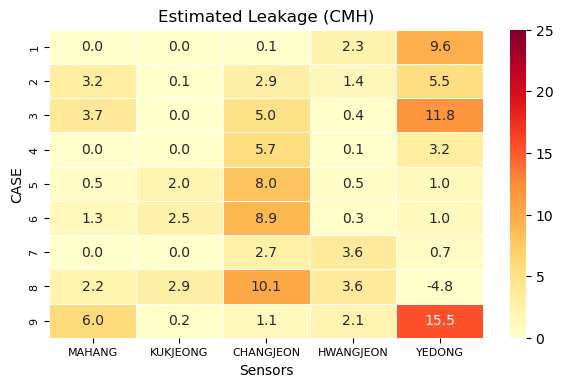

In [24]:
# GA로 분배된 유량 시각화

# subplots(): plot의 속성을 지정하는 함수
# heatmap(): 히트맵 그리는 함수
fig, ax = plt.subplots(figsize = (7, 4))  # plot사이즈
sns.heatmap(result_df,  # 데이터
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.1f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd',  # colormap
            vmin = 0,  # colormap 최소범위
            vmax = 25)  # colormap 최대범위

plt.title('Estimated Leakage (CMH)', size = 12)  # 제목
plt.ylabel('CASE', size = 10)  # ylabel
plt.xlabel('Sensors', size = 10) # xlabel

plt.xticks(size = 8) 
plt.yticks(size = 8) 
plt.show()

히트맵으로 절점별 GA로 각 절점에 분배된 유량을 살펴보면, 빨간색에 가까울 수록 유량이 많은 것을 뜻하며, 색이 연해질수록 유량이 적음을 표현합니다.
* 히트맵: 데이터를 열(heat)분포 형태로 시각화하는 방법으로, 패턴과 변화를 보여주는 데 사용됩니다.

In [25]:
## 누수 예측 지점 선택

# 누수배분 예측 df
leak_df = series_estimated_demand[all_junctions]*3600
leak_df.set_index(keys = [flow_pressure_df.index], inplace=True)
leak_df = pd.concat([leak_point_df,leak_df], axis=1)

# n번째 큰 누수량 뽑는 함수
def number_order(arr, num):
    unique_nums = set(arr)
    sorted_nums = sorted(unique_nums, reverse=True)
    return sorted_nums[num-1]

# n번째 큰 누수량에 해당하는 컬럼명(절점명) 선택하는 함수
def number_column(i, k, df):
    number = number_order(df.iloc[i, 1:], k)
    number_column = df.columns[df.iloc[i, 1:].tolist().index(number) + 1]
    return number_column

# 케이스별 예측되는 누수 위치 df
df = pd.DataFrame()
for i in range(len(leak_df)):
    predicted_point = []
    predicted_point.append(number_column(i, 1, leak_df))  # 첫번째로 큰 누수량
    if len(leak_df.iloc[i, 0].split('/'))==1:  # 누수지점이 1개일 때
        pass
    elif len(leak_df.iloc[i, 0].split('/'))==2:   # 누수지점이 2개일 때
        predicted_point.append(number_column(i, 2, leak_df))  # 두번째로 큰 누수량
    else:
        predicted_point.append(number_column(i, 2, leak_df))
        predicted_point.append(number_column(i, 3, leak_df))  # 세번째로 큰 누수량
    
    new_row = pd.Series(['/'.join(item) if isinstance(item, list) else item for item in [predicted_point]])
    df = pd.concat([df, new_row], ignore_index = True, axis=0)
    
df.columns = ['PRIDICTED_POINT']
df.set_index(keys = [flow_pressure_df.index], inplace=True)

# 실제 누수위치와 예측되는 누수 위치 비교 후 판정 df
judgment_df = pd.DataFrame()
for i in range(len(leak_df)):
    if (leak_df['LEAK_JUNC'].iloc[i] == df['PRIDICTED_POINT'].iloc[i]):  # 누수맞췄으면
        new_row = pd.Series(['OK'])
    else:  # 누수못맞췄으면
        new_row = pd.Series(['NG'])
    judgment_df = pd.concat([judgment_df, new_row], ignore_index = True, axis=0)

judgment_df.columns = ['JUDGMENT']
judgment_df.set_index(keys = [flow_pressure_df.index], inplace=True)

# df 합치기
GA_compare_df = pd.concat([leak_df, df, judgment_df], axis=1)

# df 저장
GA_compare_df.to_csv('./output/GA_result.csv')
GA_compare_df

,LEAK_JUNC,MAHANG,KUKJEONG,CHANGJEON,HWANGJEON,YEDONG,PRIDICTED_POINT,JUDGMENT
CASE,,,,,,,,
1,YEDONG,0.006,0.000,0.078000,2.340,9.576001,YEDONG,OK
2,MAHANG,3.161,0.052,2.907000,1.411,5.469000,YEDONG,NG
3,YEDONG/MAHANG,3.749,0.042,4.976000,0.386,11.847000,YEDONG/CHANGJEON,NG
4,CHANGJEON,0.018,0.003,5.734000,0.090,3.155000,CHANGJEON,OK
5,CHANGJEON,0.544,1.997,7.984000,0.464,1.011000,CHANGJEON,OK
6,CHANGJEON,1.290,2.456,8.947000,0.313,0.994000,CHANGJEON,OK
7,HWANGJEON,0.005,0.002,2.691000,3.557,0.745000,HWANGJEON,OK
8,CHANGJEON/HWANGJEON,2.246,2.928,10.098001,3.557,-4.829000,CHANGJEON/HWANGJEON,OK
9,YEDONG/MAHANG/CHANGJEON,6.018,0.210,1.099000,2.130,15.543000,YEDONG/MAHANG/HWANGJEON,NG


CASE별로 누수량이 제일 많은 곳이 누수지점입니다. 또한 누수지점이 2개 이상인 경우 모두 맞추어야 OK로 판정합니다.   
예를 들어 CASE1번을 보면 누수 위치는 YEDONG이지만, 유량이 가장 많은 지점이 KUKJEONG이기 떄문에 예상 누수 위치는 KUKJEONG입니다. 이는 누수위치가 잘못 예측됨을 알 수 있습니다.  
CASE1, 2는 누수위치탐지가 잘 안되었고, 나머지 케이스는 누수위치탐지가 잘 된 것을 볼 수 있습니다.

## 시행착오법
**[시행착오법(trial and error method)]**  
: 여러 경우의 수를 시도해서 해(solution)을 찾는 방법.  
대수적으로 해를 찾기 어려울 때 시도할 수 있는 방법임.

예시> 총 누수량 1를 3개의 절점에 배분하는 모든 경우의 수  
: [1 0 0], [0 1 0], [0 0 1] 총 3가지를 시도 할 수 있음.

### 시행착오법 함수 설정 

In [26]:
# CASE별 경우의 수 생성

# itertools.product(): 두개 이상의 리스트(or 집합)끼리의 데카르트 곱(cartesian product)를 계산하여 iterator로 반환
# 데카르트곱: 집합의 원소가 이루는 모든 순서쌍의 곱
# np.arange(시작점(생략 시 0), 끝점(미포함), step size(생략 시 1)): 수열 생성
def create_table(point, leakage, step):
    cnt = 0
    df = pd.DataFrame(columns = range(point))
    data = itertools.product(np.arange(0, (leakage+step), step), repeat = point)
    for i in data:
        if leakage<20:
            if sum(i)==leakage:
                df.loc[cnt] = i
                cnt = cnt + 1
        else:
            if sum(i)==(leakage-1):  # leakage가 20이 넘으면 경우의 수가 많아지므로 step을 2로해서 들어와서 sum(i)의 최대값이 (leakage-1)이 됨
                df.loc[cnt] = i
                cnt = cnt + 1

    return df

### 각 CASE별 시행착오법 실행
* 약 5분정도 소요됩니다.
* 생성된 엑셀들의 맨 윗줄 데이터가 CASE별 최적해입니다.

<span style = 'background:#ffd33d'> 미리 학습된 모델을 사용하지 않고 직접 모델학습을 하려면 아래의 셀의 주석을 풀고 실행하세요 </span>

In [27]:
## 미리 실행된 알고리즘을 사용하지 않고 직접 실행 하려면 이 셀의 주석을 풀고 실행하세요
# # 각 CASE별 시행착오법 실행
# Select_CASE = 9 + 1
# result_df = pd.DataFrame(columns = ['MAHANG_d','KUKJEONG_d', 'CHANGJEON_d', 'HWANGJEON_d', 'YEDONG_d'])  # 지점별 예측된 누수량 컬럼 생성

# # 시행착오법 실행
# for CASE_number in range(1, Select_CASE):  # CASE: 1 ~ 9
#     # 수압 측정 센서 위치 지정
#     Sensing_points = ['MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON', 'YEDONG']  
    
    
#     # 경우의 수 생성
#     if flow_pressure_df['START_FL'].loc[CASE_number]>=20:  # 유출유량이 20이상이면 경우의 수가 많으므로 2step씩 경우의 수를 생성
#         estimated_df = create_table(5, flow_pressure_df['START_FL'].loc[CASE_number], 2)  # CASE3, CASE9
#     else:
#         estimated_df = create_table(5, flow_pressure_df['START_FL'].loc[CASE_number], 1)

        
#     # 관망해석 준비
#     estimated_df.columns = Sensing_points
#     reservoir = wn.get_node('1')
#     reservoir.base_head = flow_pressure_df['START_PR'].loc[CASE_number]
#     measured_data = flow_pressure_df[Sensing_points].loc[CASE_number]
#     measured_pressure = pd.DataFrame(measured_data).T
#     measured_pressure = measured_pressure.reset_index(drop=True)
    
    
#     # CASE별 측정된 수압
#     temp_lst = list(flow_pressure_df[Sensing_points].loc[CASE_number])

    
#     # 경우의 수 별 관망해석 실시
#     end_time = len(estimated_df)
#     for i in range(end_time):
#         wn.reset_initial_values()

#         for sensor in Sensing_points:
#             junctions = wn.get_node(sensor)
#             junctions.demand_timeseries_list[0].base_value = estimated_df[sensor].loc[i]/3600

#         sim = wntr.sim.EpanetSimulator(wn)
#         results = sim.run_sim()
#         estimated_pressure = results.node['pressure']

        
#         # 해석수압과 측정수압의 차이(오차)
#         for sensor in Sensing_points:
#             estimated_pressure['Err_' + sensor] = (estimated_pressure[sensor].loc[0]-measured_pressure[sensor].loc[0])

#         estimated_pressure['corr'] = pearsonr(estimated_pressure[( ['MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON', 'YEDONG'])].loc[0], temp_lst)[0]

#         # 측정수압 df 생성
#         if i==0:  # CASE1
#             series_estimated_pressure = estimated_pressure
#         else:  # CASE2~9
#             series_estimated_pressure = pd.concat([series_estimated_pressure, estimated_pressure], ignore_index=True)
            
            
#     # 평가지표 계산 및 결과 df 생성
#     estimated_df.columns = ['MAHANG_d', 'KUKJEONG_d', 'CHANGJEON_d', 'HWANGJEON_d', 'YEDONG_d'] #GA로 각 절점에 분배된 유량요구
#     df2 = series_estimated_pressure.filter(regex = '[a-zA-Z]')
#     df2 = df2.reindex(columns=['MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON', 'YEDONG', 'Err_MAHANG', 'Err_KUKJEONG', 'Err_CHANGJEON', 'Err_HWANGJEON', 'Err_YEDONG', 'corr'])
#     df3 = pd.concat([estimated_df, df2], axis = 1)

#     df3['rmse'] = 0

#     for i in ['MAHANG', 'KUKJEONG', 'CHANGJEON', 'HWANGJEON', 'YEDONG']:
#         df3['rmse'] = df3['rmse'] + (df3['Err_'+i]**2) / 5

#     df3['rmse'] = np.sqrt(df3['rmse'])
#     df3['rmse_rank'] = df3['rmse'].rank(method='first', ascending = True)
#     df3['corr^2'] = df3['corr']**2

#     df3 = df3.sort_values('corr^2', ascending = False)  # 상관계수의 제곱값을 기준으로 내림차순 정렬
#     result_df.loc[CASE_number-1] = list(df3[estimated_df.columns].iloc[0])
    
#     # 컬럼이름 변경
#     df3 = df3.rename(columns={'MAHANG':'MAHANG_p', 'KUKJEONG':'KUKJEONG_p', 'CHANGJEON':'CHANGJEON_p', 'HWANGJEON':'HWANGJEON_p', 'YEDONG':'YEDONG_p',
#                        'MAHANG_d':'MAHANG', 'KUKJEONG_d':'KUKJEONG', 'CHANGJEON_d':'CHANGJEON', 'HWANGJEON_d':'HWANGJEON', 'YEDONG_d':'YEDONG'})
    
    
#     # 엑셀파일로 저장
#     df3.to_excel(f'output/CASE_{CASE_number}.xlsx')
#     print(f'CASE{CASE_number} 파일저장 완료')

# 시행착오법 결과 저장
# joblib.dump({'result_df':result_df}, 'output/trial_and_error.pkl')  # 모델저장

**위 셀에서 생성되는 엑셀파일 설명**  
MAHANG, KUKJEONG, CHANGJEON, HWANGJEON, YEDONG은 배분된 누수량(유량)을 의미하고, MAHANG_p, KUKJEONG_p, CHANGJEON_p, HWANGJEON_p, YEDONG_p는 관망해석모델이 배분된 누수량(유량)으로 계산한 해석수압 입니다.  
Err_MAHANG, Err_KUKJEONG, Err_CHANGJEON, Err_HWANGJEON, Err_YEDONG는 (실측수압-해석수압)이며, corr는 상관계수를 의미합니다.  
rmse_rank는 rmse을 오름차순으로 정렬했을 때 작은것부터 순서를 매긴 값입니다. 행들은 corr^2컬럼을 기준으로 내림차순으로 정렬이 되어있습니다. 그러므로 1행이 corr^2가 가장 큰 행이 되어 최적해가 됩니다.

In [28]:
# 시행착오법이 실행된 데이터 불러오기
# 시행착오법 실행시 시간이 오래 걸리므로 빠르게 결과를 확인하고 싶으면 이 셀을 실행한 후 4.4 실행착오법 평가로 넘어가면 됩니다.
with open('output/trial_and_error.pkl', 'rb') as f:
    trial_and_error = joblib.load(f)
locals().update(trial_and_error)  #dictionary를 받아서 key에 값을 변수로 줌

result_df = trial_and_error['result_df']

## 시행착오법 평가

In [29]:
# 컬럼이름 변졍
result_df = result_df.rename(columns={'MAHANG_d':'MAHANG', 'KUKJEONG_d':'KUKJEONG', 'CHANGJEON_d':'CHANGJEON', 'HWANGJEON_d':'HWANGJEON', 'YEDONG_d':'YEDONG'})

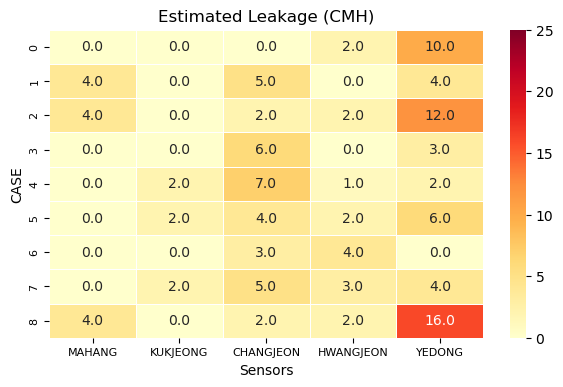

In [30]:
# 시행착오법으로 분배된 유량 시각화
fig, ax = plt.subplots(figsize = (7, 4))  # plot사이즈
sns.heatmap(result_df ,  # 데이터
            annot = True, # 숫자 표시 여부
            ax = ax, # 히트맵을 그릴 격자
            linewidths = 0.4, # 선의 굵기
            linecolor = 'white', # 선의 색깔
            fmt = '.1f', # 소수점 포맷팅 형태
            cmap = 'YlOrRd',  # colormap
            vmin = 0,  # colormap 최소범위
            vmax = 25)  # colormap 최대범위

plt.title('Estimated Leakage (CMH)', size = 12)  # 제목
plt.ylabel('CASE', size = 10)  # ylabel
plt.xlabel('Sensors', size = 10) # xlabel

plt.xticks(size = 8) 
plt.yticks(size = 8) 
plt.show()

In [31]:
# 누수 예측 지점 선택 

# 누수배분 예측 df
result_df_compare = result_df.set_index(keys = [flow_pressure_df.index])
leak_df = pd.concat([leak_point_df,result_df_compare], axis=1)

# n번째 큰 누수량 뽑는 함수
def number_order(arr, num):
    unique_nums = set(arr)
    sorted_nums = sorted(unique_nums, reverse=True)
    return sorted_nums[num-1]

# n번째 큰 누수량에 해당하는 컬럼명(절점명) 선택하는 함수
def number_column(i, k, df):
    number = number_order(df.iloc[i, 1:], k)
    number_column = df.columns[df.iloc[i, 1:].tolist().index(number) + 1]
    return number_column

# 케이스별 예측되는 누수 위치 df
df = pd.DataFrame()
for i in range(len(leak_df)):
    predicted_point = []
    predicted_point.append(number_column(i, 1, leak_df))  # 첫번째로 큰 누수량
    if len(leak_df.iloc[i, 0].split('/'))==1:  # 누수지점이 1개일떄
        pass
    elif len(leak_df.iloc[i, 0].split('/'))==2:  # 누수지점이 2개일떄
        predicted_point.append(number_column(i, 2, leak_df))  # 두번째로 큰 누수량
    else:
        predicted_point.append(number_column(i, 2, leak_df))
        predicted_point.append(number_column(i, 3, leak_df))  # 세번째로 큰 누수량
    
    new_row = pd.Series(['/'.join(item) if isinstance(item, list) else item for item in [predicted_point]])
    df = pd.concat([df, new_row], ignore_index = True, axis=0)
    
df.columns = ['PRIDICTED_POINT']
df.set_index(keys = [flow_pressure_df.index], inplace=True)

# 실제 누수위치와 예측되는 누수 위치 비교 후 판정 df
judgment_df = pd.DataFrame()
for i in range(len(leak_df)):
    if (leak_df['LEAK_JUNC'].iloc[i] == df['PRIDICTED_POINT'].iloc[i]):  # 누수맞췄으면
        new_row = pd.Series(['OK'])
    else:  # 누수못맞췄으면
        new_row = pd.Series(['NG'])
    judgment_df = pd.concat([judgment_df, new_row], ignore_index = True, axis=0)

judgment_df.columns = ['JUDGMENT']
judgment_df.set_index(keys = [flow_pressure_df.index], inplace=True)

# df 합치기
trial_and_error_compare_df = pd.concat([leak_df, df, judgment_df], axis=1)

# df 저장
trial_and_error_compare_df.to_csv('./output/trial_and_error_result.csv')
trial_and_error_compare_df

,LEAK_JUNC,MAHANG,KUKJEONG,CHANGJEON,HWANGJEON,YEDONG,PRIDICTED_POINT,JUDGMENT
CASE,,,,,,,,
1,YEDONG,0,0,0,2,10,YEDONG,OK
2,MAHANG,4,0,5,0,4,CHANGJEON,NG
3,YEDONG/MAHANG,4,0,2,2,12,YEDONG/MAHANG,OK
4,CHANGJEON,0,0,6,0,3,CHANGJEON,OK
5,CHANGJEON,0,2,7,1,2,CHANGJEON,OK
6,CHANGJEON,0,2,4,2,6,YEDONG,NG
7,HWANGJEON,0,0,3,4,0,HWANGJEON,OK
8,CHANGJEON/HWANGJEON,0,2,5,3,4,CHANGJEON/YEDONG,NG
9,YEDONG/MAHANG/CHANGJEON,4,0,2,2,16,YEDONG/MAHANG/CHANGJEON,OK


CASE별로 누수량이 제일 많은 곳이 누수지점입니다.  또한 누수지점이 2개 이상인 경우 모두 맞추어야 OK로 판정합니다.  
예를 들어 CASE2번을 보면 누수 위치는 MAHANG이지만, 유량이 가장많은 지점이 CHANGJEON이기 때문에 예상 누수 위치는 CHANGJEON입니다. 이는 누수위치가 잘못 예측됨을 알 수 있습니다.  
CASE1, 3, 4, 5, 7, 9 에서는 누수위치를 정확히 맞추었으나 CASE2, 6, 8에서는 누수위치를 정확히 맞추지 못했습니다.

# 학습포인트
* EPANET 관망해석 모델 관련 파이썬 패키지 wntr을 활용하여 해석수압 계산 
* 수압데이터 분석을 통해 EPANET 모델과 유전 알고리즘, 시행착오법을 연계하여 배수관망 내 누수 위치 탐지
* 누수 위치 탐지 모델의 신뢰성 검증을 위해 인위적인 누수를 조성하는 모의실험(blind test)를 실시하여 실측 값과 분석 값 비교

# 레시피 정보

* 디지털 물산업 분야 학습용 예제 레시피 제작
* 생성일자: 2023년 05월 31일
* 사용언어: Python
* Kwater 빅데이터콘테스트 발표연도 및 부서: 2022년/정읍권지사